# VQE in DFT with PsiEmbed and Qiskit

Here we define the inputs as required by PsiEmbed. Note that we'll follow the logic of `embedding_module/run_open_shell`.

We can think of this procedure are requiring three steps:

1. Pre-embedding

    Here we define the problem, and run a low-level calculation of the whole system. From this we obtain the pre-embedded density matrices $\gamma^A$ and $\gamma^B$

    We then define the level-shift projector $P$ and embedding potential $V_{emb}$.

2. Embedding

    Using $V_{emb}$ we run a high-level method simulation of the active region to get the embedded density matrix $\gamma^A_{emb}$.

    We calculate the correction term $tr[V_{emb}(\gamma^A_{emb}-\gamma^A)]$

3. Post-embedding

    Finally we calculate the embedded energy, by removing $V_{emb}$ from the Hamiltonian, and using density matrix $\gamma^A_{emb}$.

    The total energy is then given by: $E = E[\gamma^A_{emb}] + E[\gamma^B] + g[\gamma^A, \gamma^B] + E_{nuclear} + tr[V_{emb}(\gamma^A_{emb}-\gamma^A)]$

# 0. Set Parameters

First we'll set the parameters 

In [21]:
from copy import copy
from typing import Dict
from spade import fill_defaults
import numpy as np
from scipy import linalg
from spade.main import driver
from spade.embedding_module import run_closed_shell

ethane = """
C      0.7516     -0.0225     -0.0209
C     -0.7516      0.0225      0.0209
H      1.1851     -0.0039      0.9875
H      1.1669      0.8330     -0.5693
H      1.1155     -0.9329     -0.5145
H     -1.1669     -0.8334      0.5687  
H     -1.1157      0.9326      0.5151
H     -1.1850      0.0044     -0.9875
    """

ethylene = """
C    3.402   0.773  -9.252
C    4.697   0.791  -8.909
H    2.933  -0.150  -9.521
H    2.837   1.682  -9.258
H    5.262  -0.118  -8.904
H    5.167   1.714  -8.641
    """

methanol = """
H     -1.1326     -0.0311     -0.6482
O     -0.6582     -0.0067      0.1730 
C      0.7031      0.0083     -0.1305
H      1.2001      0.0363      0.8431
H      0.9877      0.8943     -0.7114
H      1.0155     -0.8918     -0.6742
  """
# H     -1.1326     -0.0311     -0.6482 <--- this goes with the oxygen


formadehyde = """
C      0.5979      0.0151      0.0688
O     -0.5960     -0.0151     -0.0686
H      1.0686     -0.1411      1.0408
H      1.2687      0.2002     -0.7717
  """

water = """
O          0.00000        0.00000        0.1653507
H          0.00000        0.7493682     -0.4424329
H          0.00000       -0.7493682     -0.4424329
    """

options = {}
options['geometry'] = water
options['n_active_atoms'] = 1 # number of active atoms (first n atoms in the geometry string)
options['basis'] = 'STO-6G' # basis set 
options['low_level'] = 'b3lyp' # level of theory of the environment 
options['high_level'] = 'mp2' # level of theory of the embedded system
options['low_level_reference'] = 'rhf'
options['high_level_reference'] = 'rhf'
options['package'] = 'pyscf'

keywords = fill_defaults(options)

#run_closed_shell(keywords)

# 1. Low-level whole system calculation

The first step is to run a mean field caluclation of the whole system.

The Embed class and its subclasses have a method to do this which also sets the following properties:
    Exchange correlation potentials (v_xc_total if embedding potential is not set, or alpha/beta_v_xc_total)
    

In [22]:
from pyscf import gto, scf, cc, ao2mo, fci

mol = gto.Mole(atom=keywords['geometry'], basis=keywords['basis'], charge=0).build()

ks = scf.RKS(mol)
ks.conv_tol = keywords["e_convergence"]
ks.xc = keywords["low_level"]
e_initial = ks.kernel()

# Store the initial value of h core as this is needed later,
# but is overwritten

initial_h_core = ks.get_hcore()

mol_copy = copy(mol)

converged SCF energy = -76.0010943374088


In [23]:
ks.mo_coeff.shape

(7, 7)

In [24]:
ks.mo_coeff.shape

(7, 7)

In [25]:
hf = mol_copy.RHF().run()

ref_fci = fci.FCI(hf)
ref_fci.conv_tol = keywords["e_convergence"]
fci_result = ref_fci.kernel()

# This DOES have nuclear energy included!
expected_energy = fci_result[0]

# What units is this in?
f"{expected_energy=}"

converged SCF energy = -75.680090378264


'expected_energy=-75.73152218912338'

# 2. Orbital Localisation
Find the orbitals of the active space and environment, using SPADE.

In [26]:
n_occupied_orbitals = np.count_nonzero(ks.mo_occ == 2)
occupied_orbitals = ks.mo_coeff[:, :n_occupied_orbitals]

n_act_aos = mol.aoslice_by_atom()[keywords['n_active_atoms']-1][-1]
ao_overlap = ks.get_ovlp()

# Orbital rotation and partition into subsystems A and B
#rotation_matrix, sigma = embed.orbital_rotation(occupied_orbitals,
#    n_act_aos, ao_overlap)

rotated_orbitals = linalg.fractional_matrix_power(ao_overlap, 0.5) @ occupied_orbitals
_, sigma, right_vectors = linalg.svd(rotated_orbitals[:n_act_aos, :])

#n_act_mos, n_env_mos = embed.orbital_partition(sigma)
value_diffs = sigma[1:]-sigma[:-1]
n_act_mos = np.argmin(value_diffs) + 1
n_env_mos = len(sigma) - n_act_mos

# Defining active and environment orbitals and 
act_orbitals = occupied_orbitals @ right_vectors.T[:, :n_act_mos]
env_orbitals = occupied_orbitals @ right_vectors.T[:, n_act_mos:]
act_density = 2.0 * act_orbitals @ act_orbitals.T
env_density = 2.0 * env_orbitals @ env_orbitals.T

In [27]:
occupied_orbitals.shape

rotated_orbitals.shape

rotated_orbitals[:n_act_aos, :].shape

mol.aoslice_by_atom()

array([[0, 3, 0, 5],
       [3, 4, 5, 6],
       [4, 5, 6, 7]])

# 3. Calculate the cross subsytem terms

In [28]:
# Retrieving the subsytem energy terms and potential matrices

# The function called looks like this
def closed_shell_subsystem(scf, density):
        #It seems that PySCF lumps J and K in the J array 
        j = ks.get_j(dm = density)
        k = np.zeros(np.shape(j))
        two_e_term =  ks.get_veff(ks.mol, density)
        e_xc = two_e_term.exc
        v_xc = two_e_term - j

        # Energy
        e = np.einsum("ij,ij", density, ks.get_hcore() + j/2) + e_xc
        return e, e_xc, j, k, v_xc

e_act, e_xc_act, j_act, k_act, v_xc_act = (
    closed_shell_subsystem(scf, act_density))
e_env, e_xc_env, j_env, k_env, v_xc_env = (
    closed_shell_subsystem(scf, env_density))

# Computing cross subsystem terms
# Note that the matrix dot product is equivalent to the trace.
j_cross = 0.5 * (np.einsum("ij,ij",act_density, j_env)
        + np.einsum("ij,ij", env_density, j_act))

k_cross = 0.0

xc_cross = ks.get_veff().exc - e_xc_act - e_xc_env
two_e_cross = j_cross + k_cross + xc_cross
print(f"{e_act=},{e_xc_act=}")#, {j_act=}, {k_act=}, {v_xc_act=}")
f"{two_e_cross=}, {xc_cross=}"

e_act=-78.07244645155404,e_xc_act=-7.237060261886795


'two_e_cross=16.18037188035646, xc_cross=-0.4321262225057012'

# 4. Define $V_{emb}$

We can now define the projector used to orthogonalise the Molecular and Atomic orbitals. From this we calculate the embedding potential.

$P_{\alpha, \beta} = S\gamma^BS$

From this we can now also define the embedding potential.

$V_{emb} = g[\gamma^A, \gamma^B] - g[\gamma^A] + \mu P$

In [29]:
# Define the mu-projector
print(f"{keywords['level_shift']=}")
projector = keywords['level_shift'] * (ks.get_ovlp() @ env_density
    @ ks.get_ovlp())

v_xc_total = ks.get_veff() - ks.get_j()

# Defining the embedded core Hamiltonian
v_emb = (j_env + v_xc_total - v_xc_act + projector)

keywords['level_shift']=1000000.0


# 5A Run HF of full system with $V_{emb}$ to get $\gamma^A_{emb}$

Here, PsiEmbed gives us the option to stop, outputting values for calculation by other means.

To continue, we run the mean field method, but with the embedding potentials as calulated.

In [30]:
embedded_scf = scf.RHF(mol)
embedded_scf.conv_tol = keywords["e_convergence"]
embedded_scf.mol.nelectron = 2*n_act_mos

h_core = embedded_scf.get_hcore()

embedded_scf.get_hcore = lambda *args, **kwargs: h_core + v_emb

embedded_scf.kernel()

embedded_occ_orbs = embedded_scf.mo_coeff[:, embedded_scf.mo_occ>0]
embedded_density = 2*embedded_occ_orbs @ embedded_occ_orbs.T

e_emb = embedded_scf.energy_elec(dm=embedded_density, vhf=embedded_scf.get_veff())[0]

print(f"{e_emb=}")

converged SCF energy = -52.4702397092794
e_emb=-61.59852343756237


/home/mwilliams/anaconda3/envs/mres/lib//python3.8/site-packages/pyscf/gto/mole.py:1089: UserWarning: Function mol.dumps drops attribute _nelectron because it is not JSON-serializable
  warnings.warn(msg)


# 6 Calculate correction term

In [31]:
# Compute the correction
# - There are two versions used for different embeddings
dm_correction = np.einsum("ij,ij", v_emb, embedded_density - act_density)
wf_correction = np.einsum("ij,ij", act_density, v_emb)

print(f"{wf_correction=}, {dm_correction=}")

wf_correction=16.308795641874894, dm_correction=-0.0008673600709698803


In [32]:
embedded_density.shape

(7, 7)

# 7 Calculate $E[\gamma^A_{emb}]$

We calculate the Hartree-fock energy of the embedded region, we then add correlation later.

# Get Qubit Hamiltonian

In [33]:
env_indices = [i+n_act_mos for i in range(n_env_mos)]
active_indices = [i for i in range(embedded_scf.mol.nao) if i not in env_indices]
occupied_indices = embedded_scf.mo_occ == 2
occupied_indices = [i for i, val in enumerate(occupied_indices) if val]

print(f"{env_indices=} \n {active_indices=} \n {occupied_indices=}")

env_indices=[3, 4] 
 active_indices=[0, 1, 2, 5, 6] 
 occupied_indices=[0, 1, 2]


In [34]:
from pyscf import ao2mo

one_body_integrals = embedded_scf.mo_coeff.T @ h_core @ embedded_scf.mo_coeff

eri = mol.intor("int2e", aosym=1)
# This said embedded_scf._eri before
mo_eri = ao2mo.incore.full(eri, embedded_scf.mo_coeff, compact=False)
two_body_integrals = mo_eri.reshape(mol.nao, mol.nao, mol.nao, mol.nao)

In [35]:
from openfermion.ops.representations import InteractionOperator, get_active_space_integrals
from openfermion.linalg import eigenspectrum, expectation
from openfermion.transforms import jordan_wigner

_, act_one_body, act_two_body = get_active_space_integrals(one_body_integrals, 
    two_body_integrals,
    active_indices=active_indices,
    occupied_indices=occupied_indices,
    )

print(f"{act_one_body.shape=}, {act_two_body.shape=}")

molecular_hamiltonian = InteractionOperator(0,
                                            act_one_body,
                                            0.5 * act_two_body)

Qubit_Hamiltonian = jordan_wigner(molecular_hamiltonian)

# Looks like the Qubit Hamiltonian contains nuclear energy
e_vqe_act = eigenspectrum(Qubit_Hamiltonian)[0]

print(f"{e_vqe_act=}, {e_env=}, {two_e_cross=}, {wf_correction=}")


act_one_body.shape=(5, 5), act_two_body.shape=(5, 5, 5, 5)
e_vqe_act=-54.26764874552573, e_env=-23.237303494494267, two_e_cross=16.18037188035646, wf_correction=16.308795641874894


In [36]:
eigenspectrum(Qubit_Hamiltonian)

array([-5.42676487e+01, -4.80385491e+01, -4.79976190e+01, -4.78384073e+01,
       -4.70816791e+01, -4.17685193e+01, -4.16093077e+01, -4.15683775e+01,
       -4.08525795e+01, -4.08116493e+01, -4.06524377e+01, -3.53392779e+01,
       -3.45825497e+01, -3.44233380e+01, -3.43824079e+01, -2.81533083e+01,
       -2.61143405e+01, -1.98852409e+01, -1.98443107e+01, -1.96850991e+01,
       -1.89283708e+01, -1.36152111e+01, -1.34559994e+01, -1.34150693e+01,
       -1.26992712e+01, -1.26583411e+01, -1.24991294e+01, -7.18596964e+00,
       -6.42924143e+00, -6.27002978e+00, -6.22909963e+00,  8.88178420e-16])

In [39]:
print(f"{act_one_body=} \n {act_two_body.shape=}")

act_one_body=array([[-2.81404940e+01,  1.45131605e-01, -7.17636726e-12,
         5.04297329e-01,  3.86849935e-12],
       [ 1.45131605e-01, -6.51393119e+00,  3.80320916e-12,
         4.33826269e-01, -2.87259962e-10],
       [-7.17636726e-12,  3.80320916e-12, -6.42924143e+00,
         1.53013608e-11,  5.21808584e-11],
       [ 5.04297329e-01,  4.33826269e-01,  1.53013608e-11,
        -6.91395233e+00, -6.70453052e-12],
       [ 3.86839327e-12, -2.87259855e-10,  5.21808584e-11,
        -6.70457091e-12, -6.27002978e+00]]) 
 act_two_body.shape=(5, 5, 5, 5)


# 8. Add all the parts up.

e_act_emb : $\epsilon[\gamma^A_{emb}]$
>energy of the embedded region

e_env : $E[\gamma^B]$ 
>energy of the environment

two_e_cross : $g[\gamma^A, \gamma^B]$
>non-additive two electron term

embed.nre
>The Coulomb energy from nuclear repulsion.

correction : $tr[(\gamma^A_{emb} - \gamma^A)(h^{A in B} - h)]$ (or $tr[\gamma^A(h^{A in B} - h)]$ )
> Correction for embedding

In [40]:
expected_energy= -77.98922635296347

In [41]:
e_nuc = mol.energy_nuc()

# Why does subtraacting the dft correction work ? Coincidence? TODO
e_mf_emb = e_vqe_act + e_env + two_e_cross + e_nuc + dm_correction
print("Component contributions")
print(f"{e_vqe_act=}, {e_env=}, {two_e_cross=}, {wf_correction=}, {dm_correction=}, {e_nuc=}\n")

# Print out the final value.
print(f"FCI Energy:\t\t{expected_energy}")
print(f"DFT Energy:\t\t{e_initial}")
print(f"Error:\t\t\t{(expected_energy-e_initial)*100/expected_energy:.2f}%")
print(f"Embedding Energy:\t{e_mf_emb}")
print(f"Error:\t\t\t{(expected_energy-e_mf_emb)*100/expected_energy:.2f}%")


Component contributions
e_vqe_act=-54.26764874552573, e_env=-23.237303494494267, two_e_cross=16.18037188035646, wf_correction=16.308795641874894, dm_correction=-0.0008673600709698803, e_nuc=9.128283728282938

FCI Energy:		-77.98922635296347
DFT Energy:		-76.00109433740884
Error:			2.55%
Embedding Energy:	-52.197163991451575
Error:			33.07%


In [ ]:
# This is just here to quit any "Run All" commands
import pdb;pdb.set_trace()

# Tequila

In [42]:
import tequila as tq
from tequila.quantumchemistry import ParametersQC, QuantumChemistryBase, QuantumChemistryPySCF
from tequila import ExpectationValue
from tequila.quantumchemistry.qc_base import ClosedShellAmplitudes
#tq_mol = QuantumChemistryBase.do_make_molecule(self, nuclear_repulsion=0, one_body_integrals=act_one_body, two_body_integrals=act_two_body)

In [43]:
params = ParametersQC(basis_set=keywords["basis"], geometry=keywords["geometry"])
driver = QuantumChemistryPySCF(parameters=params, transformation="jordan_wigner", one_body_integrals=act_one_body, two_body_integrals=act_two_body)
#tq_mol = driver.make_molecule(one_body_integrals=act_one_body, two_body_integrals=act_two_body)

/home/mwilliams/anaconda3/envs/mres/lib//python3.8/site-packages/tequila/quantumchemistry/pyscf_interface.py:36: TequilaWarning: PySCF Interface: No constant part (nuclear repulsion)
  warnings.warn("PySCF Interface: No constant part (nuclear repulsion)", TequilaWarning)


In [44]:
amps = ClosedShellAmplitudes(tIA=act_one_body, tIjAb=act_two_body)
U = driver.make_uccsd_ansatz(trotter_steps=1, initial_amplitudes=amps)
H = driver.make_hamiltonian()

E = ExpectationValue(H=H, U=U)

In [45]:
#E = tq.ExpectationValue(H=H, U=U, transformation="jordan_wigner")
result = tq.minimize(objective=E, method="cobyla", initial_values=None)

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qiskit
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 1 expectationvalues

active variables : 174

> /home/mwilliams/anaconda3/envs/mres/lib/python3.8/site-packages/tequila/simulators/simulator_qiskit.py(275)do_simulate()
    273 
    274         import pdb;pdb.set_trace()
--> 275         backend_result = qiskit.execute(experiments=self.circuit, optimization_level=optimization_level,
    276                                         backend=qiskit_backend, parameter_binds=[self.resolver],
    277                                         **opts).result()

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


ERROR: Failed to load qobj: Unable to cast Python instance to C++ type (compile in debug mode for details)


QiskitError: 'Data for experiment "circuit-2" could not be found.'

# Pennylane

In [ ]:
# Can either convert to pennylane or generate a Fermionic operator in pl
import pennylane_qchem as pl
import pennylane as qml

pl_qham = pl.qchem.convert_observable(Qubit_Hamiltonian)

dev = qml.device("default.qubit", wires=n_qubits)
n_electrons = n_act_mos
hf = pl.qchem.hf_state(n_electrons, n_qubits)
print(hf)

[1 1 1 0 0]


In [ ]:
from openfermion.circuits import uccsd_generator
import cirq


In [ ]:
anzats = uccsd_generator(act_one_body, act_two_body)

circuit = cirq.Circuit()
simulator = cirq.Simulator()





## Qiskit Stuff Below here

In [ ]:
qh_terms = Qubit_Hamiltonian.terms
n_qubits = molecular_hamiltonian._n_qubits

intermediate = {}
for term, value in qh_terms.items():
    # Assume I for each qubit unless explicity stated
    op_string = ["I"]*n_qubits
    for pauli in term:
        position = pauli[0]
        operator = pauli[1]

        op_string[position] = operator

    intermediate["".join(op_string)] = value

print(intermediate)

{'IIIII': -21.64487889318856, 'ZIIII': 16.506730193546527, 'IZIII': 3.8372969342080276, 'IIZII': 3.734616244736112, 'IIIZI': 3.5080188268760666, 'IIIIZ': 3.1865004221047655, 'XXIII': 0.26266275677787526, 'YYIII': 0.26266275677787526, 'XZZXI': 0.19476028221292538, 'YZZYI': 0.19476028221292538, 'IXZXI': 0.2452476834638882, 'IYZYI': 0.2452476834638882}


In [ ]:
from qiskit.opflow import I, X, Y, Z

opdict = {"I": I, "X": X, "Y": Y, "Z": Z}

# Initialise the operator with the identity contribution
qiskit_op = intermediate["I"*n_qubits] * I.tensorpower(n_qubits)

for op, value in intermediate.items():

    if op == "I"*n_qubits:
        continue

    paulis = [opdict[pauli] for pauli in op]

    pauli_product = paulis[0]
    for p in paulis[1:]:
        pauli_product = pauli_product.tensor(p)

    qiskit_op += value * pauli_product

print(qiskit_op)

-21.64487889318856 * IIIII
+ 16.506730193546527 * ZIIII
+ 3.8372969342080276 * IZIII
+ 3.734616244736112 * IIZII
+ 3.5080188268760666 * IIIZI
+ 3.1865004221047655 * IIIIZ
+ 0.26266275677787526 * XXIII
+ 0.26266275677787526 * YYIII
+ 0.19476028221292538 * XZZXI
+ 0.19476028221292538 * YZZYI
+ 0.2452476834638882 * IXZXI
+ 0.2452476834638882 * IYZYI


In [ ]:
type(qiskit_op)

qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp

In [ ]:
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import VQE
from qiskit import Aer
from qiskit_nature.circuit.library import UCCSD

from qiskit_nature.algorithms import GroundStateEigensolver


In [ ]:
from qiskit_nature.algorithms import VQEUCCFactory
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

q_instance = QuantumInstance(backend=Aer.get_backend('qasm_simulator'))
optimizer = COBYLA(maxiter=80)
esp = ElectronicStructureProblem()



vqe = VQEUCCFactory(q_instance, optimizer).get_solver()


TypeError: __init__() got an unexpected keyword argument 'num_orbitals'

In [ ]:
algorithm_globals.random_seed = 50
ansatz = UCCSD(num_orbitals=n_qubits*2, num_particles=n_act_mos*2)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
            quantum_instance=q_instance)
result = vqe.compute_minimum_eigenvalue(operator=qiskit_op)
print('\rOptimization complete      ')

/home/mwilliams/anaconda3/envs/mres/lib/python3.8/site-packages/qiskit/chemistry/fermionic_operator.py:386: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  pauli_list = WeightedPauliOperator(paulis=[])
/home/mwilliams/anaconda3/envs/mres/lib/python3.8/site-packages/qiskit/chemistry/fermionic_operator.py:386: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  pauli_list = WeightedPauliOperator(paulis=[])
/home/mwilliams/anaconda3/envs/mres/lib/python3.8/site-packages/qiskit/chemistry/fermionic_operator.py:386: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit

AttributeError: 'UCCSD' object has no attribute 'parameters'

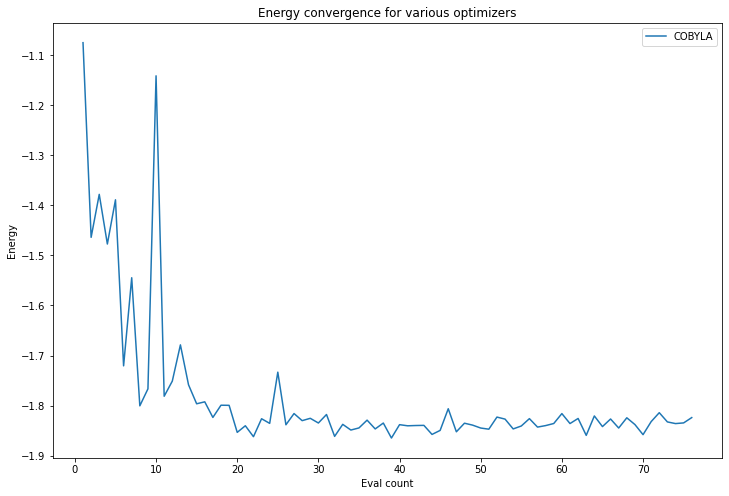

In [ ]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(counts, values, label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

referenece values

In [ ]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.85728


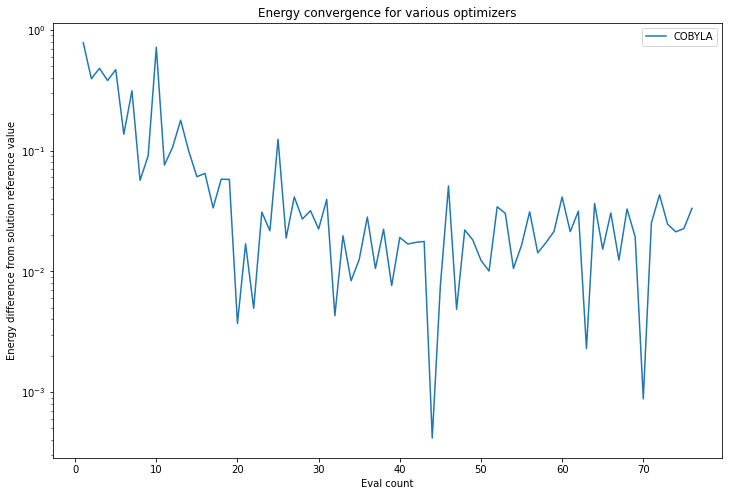

In [ ]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(counts, abs(ref_value - values), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right');